<a href="https://colab.research.google.com/github/Manav-Aggarwal4/MLP-from-Scratch/blob/main/pytorch_fundies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome to Colab! It's just like Jupyter, but you can use the power of GPUs.

Make sure to go to Runtime > Change runtime types and choose GPU or TPU.

Also, in Tools > Settings > Miscellaneous you can enable Corgi Mode.

In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils import data

import time
import json

import requests
import tqdm
import numpy as np

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Exercise 1: Linear Models in Pytorch
In this section we'll present some rather contrived examples to help you get acustomed to using pytorch.

## Exercsise 1.1: Linear Regression Without NN
Your first task is to use pytorch to run linear regression without using the neural network (or nn) package. You can construct variables that auto diff should capture by setting `tensor.requires_grad = True`. Below is some data that we'll try to fit.


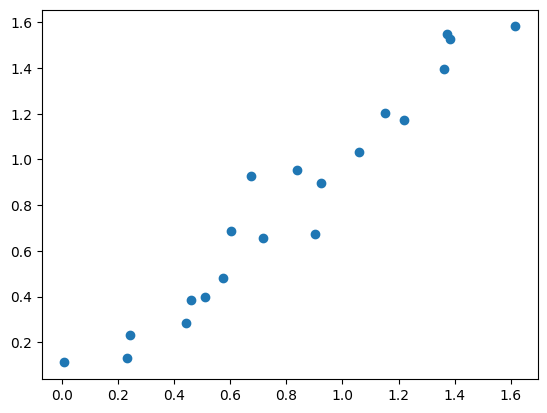

In [2]:
from matplotlib import pyplot as plt
num_data = 20

def gen_data(n):
    x = []
    y = []
    for i in range(n):
        rand = abs(np.random.randn())
        x += [rand]
        y += [.15 * np.random.randn() + rand]
    x, y = np.array(x), np.array(y)
    return x, y

X, y = gen_data(num_data)
plt.scatter(X, y)
plt.show()

L2 Loss step 0 : 0.8854450583457947
L2 Loss step 10 : 0.21029901504516602
L2 Loss step 20 : 0.0335070826113224
L2 Loss step 30 : 0.017502760514616966
L2 Loss step 40 : 0.02745719626545906
L2 Loss step 50 : 0.0132449297234416
L2 Loss step 60 : 0.014881622977554798
L2 Loss step 70 : 0.013575992546975613
L2 Loss step 80 : 0.013125826604664326
L2 Loss step 90 : 0.013081192970275879


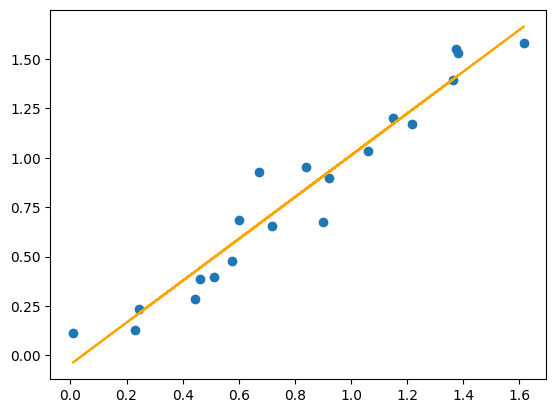

In [3]:
## YOUR TASK: Fit the data with a linear model
weight = torch.tensor(0.0, requires_grad=True, dtype=torch.float32)  # Random initial weight
bias = torch.tensor(0.0, requires_grad=True, dtype=torch.float32)  # Random initial bias

# Convert NumPy arrays to PyTorch tensors
inputs = torch.from_numpy(X).float().to(DEVICE)  # Input tensor
labels = torch.from_numpy(y).float().to(DEVICE)  # Target tensor

optimizer = torch.optim.Adam([weight, bias], lr=1)  # Include model parameters
num_steps = 100

for i in range(num_steps):
  # Zero gradients for the optimizer
  optimizer.zero_grad()
  # Compute output of linear model using weight & bias
  preds = weight * inputs + bias
  # Compute loss
  loss = torch.mean((preds - labels) ** 2)
  # Backpropagate gradients & run optimizer
  loss.backward()  # Compute gradients of loss w.r.t. parameters
  optimizer.step()  # Update weight and bias

  if i % 10 == 0:
    print("L2 Loss step", i, ":", loss.item())

# Get the final predictions and add them to the plot
with torch.no_grad():
  pred = weight * inputs + bias  # Compute final predictions
  # Convert pred to numpy array
  pred = pred.cpu().numpy()  # Convert to NumPy array for plotting

plt.scatter(X, y)
plt.plot(X, pred, color='orange')
plt.show()


## Exercise 1.2: Logistic Regression with Torch.nn
Figure out how to do linear regression using torch.nn. If you can do that, you should be able to do logistic! Let's do a simple logistic regression using torch.nn and torch.nn.Modules!

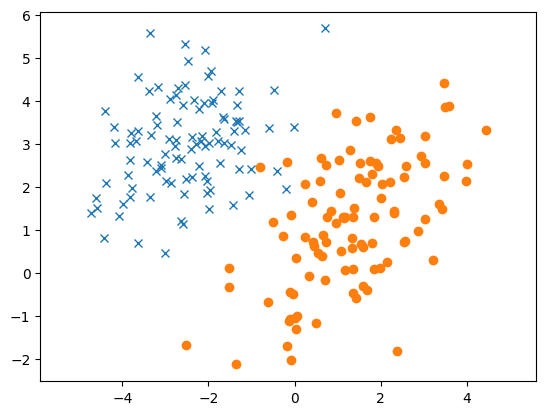

In [ ]:
# Let's generate the data
c1_x1, c1_x2 = np.random.multivariate_normal([-2.5,3], [[1, 0.3],[0.3, 1]], 100).T
c2_x1, c2_x2 = np.random.multivariate_normal([1,1], [[2, 1],[1, 2]], 100).T
c1_X = np.vstack((c1_x1, c1_x2)).T
c2_X = np.vstack((c2_x1, c2_x2)).T
X = np.concatenate((c1_X, c2_X))
y = np.concatenate((np.zeros(100), np.ones(100)))
# Shuffle the data
permutation = np.random.permutation(X.shape[0])
X = X[permutation, :]
y = y[permutation]

plt.plot(c1_x1, c1_x2, 'x')
plt.plot(c2_x1, c2_x2, 'o')
plt.axis('equal')
plt.show()

Now try and run logistic regression on the data using torch.nn and give the final accuracy. We have less skeleton code for this part!

In [ ]:
## Your code here!

class Perceptron(nn.Module):
  def __init__(self, in_dim):
    super().__init__()
    # Initialize layers you need.
    # Remember that logistic regression uses o(Wx + b) as the model
    # where o is the logistic function.
    # What layers would you need? (Need to be initialized here.)
    # What functions without weights would you need?
    # (You don't need to declare those here.)
    self.linear = nn.Linear(in_dim, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    # Compute the output of the perceptron.
    # Any functions without weights from torch.nn.functional
    # would be used here.
    out = self.linear(x)
    out = self.sigmoid(out)
    return out

net = Perceptron(2)
optimizer = torch.optim.Adam(net.parameters(), lr=1)
criterion = ... # Binary cross entropy

inputs = torch.from_numpy(X).float()
labels = ...
num_steps = 100
for i in range(num_steps):
  ... # Training loop!
  if i % 10 == 0:
    print("BCE Loss step", i, ":", loss.item())

# We can run predictions on the data to determine the final accuracy.
with ...: # Disable gradients
    # Compute predictions
    ...
    # Compute accuracy
    ...
    # Print
    ...

## Exercise 2: Neural Networks

For this workshop we will be training a Pytorch neural network to predict whether a player won or lost in League of Legends. (Technically, since we're using data from the game itself, it's not really a prediction. That would require only using player data that was known before the game started. But this is a much easier problem and it was easier to get data about the game than the player :P)

Because it can take a while to download match data from the Riot API, we've predownloaded a dataset of about 200 games.

In [ ]:
def load(url):
    return requests.get(url).json()

matches = load("http://drive.google.com/uc?id=1OLj5jlhquedQTIYj9Pm3VdVYZ7vTu5md")

To keep things simple we'll just look at a few preselected stats.

In [ ]:
FIELDS = ["kills", "deaths", "assists", "magicDamageDealt",
          "physicalDamageDealt", "trueDamageDealt", "totalHeal",
          "damageSelfMitigated", "magicalDamageTaken", "physicalDamageTaken",
          "trueDamageTaken", "totalMinionsKilled", "damageDealtToObjectives",
          "timeCCingOthers", "champLevel", "damageDealtToTurrets",
          "goldEarned"]

def get_data(entry):
    entry = entry["stats"]
    return [entry[field] for field in FIELDS] + [entry["win"]] # the last column is y, whether they w

def get_all_datas(matches):
    datas = []
    for match in matches:
        if 'participants' in match:
            for player in match['participants']:
                datas.append(get_data(player))
    return datas

match_datas = get_all_datas(matches)

In [ ]:
class MatchDataset(data.Dataset):
    def __init__(self, match_datas):
        self.datas = match_datas
        self.center_data()

    def center_data(self):
        for i in range(len(self.datas[0])-1):
            mean = np.mean([datum[i] for datum in self.datas])
            stdev = np.std([datum[i] for datum in self.datas])
            for j in range(len(self.datas)):
                self.datas[j][i] -= mean
                self.datas[j][i] /= stdev

    # YOUR CODE HERE
    # Hint: what methods do you need to implement for a subclass of torch.utils.data.Dataset?
    # (See https://pytorch.org/docs/stable/data.html#map-style-datasets)

dataset = MatchDataset(match_datas)
num_train = (len(dataset) * 8) // 10
num_test = len(dataset) - num_train
train, test = ... # YOUR CODE HERE: Train/test split. Hint: Use torch.utils.data.random_split

In [ ]:
class FCNet(...): # YOUR CODE HERE: What should FCNet inherit from?
    def __init__(self):
        super().__init__()
        # YOUR CODE HERE: Define layers
        ...
        self.apply(init_weights)

    def forward(self, x):
        ... # YOUR CODE HERE

# Implement weight initialization based on this stack overflow guide:
# https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
# You can initialize the weights however you want,
# the solution uses Xavier uniform initialization for Linear layers.
def init_weights(m):
    ... # YOUR CODE HERE

In [ ]:
# YOUR CODE HERE: Create the network, choose an optimizer and loss function
for epoch in range(100):
    # Loop over batches from the data loader.
    # You can use batch[:, :-1] and batch[:, -1] to get xs and ys from a batch.
    # Then, generate prediction probabilities, compute loss and backpropagate.
    # Make sure to also track the number of accurate and total number of predictions,
    # and append each loss to a losses array for statistics.
    # We removed some skeleton from this problem, so please ask us
    # on Slack if you have any questions!
    print(f"epoch: {epoch}, loss: {np.mean(losses)}, {accurate}/{total} correct (accuracy {accurate/total})")
    should_train = True

In [ ]:
losses = []
total = 0
accurate = 0
for batch in data.DataLoader(test, batch_size=1, shuffle=False):
    # TODO: Evaluate on test dataset, update total, accurate, and losses.
print(f"Test loss: {np.mean(losses)}.  {accurate}/{total} corrrect (accuracy {accurate/total})")

For fun: If you want to try running your own queries and predicting different quantities, the Riot API is at https://developer.riotgames.com.

You'll need to sign up and get a token to be able to use it, but it's free to use.

I wrote a function called `riot_request` that makes it a bit easier to query the API. Just set the endpoint and TOKEN and it will automatically retry every 15s if you hit the rate limit of 100 requests/min

In [ ]:
PLAYERS=['C9 Sven', 'integerliteral', 'Launchpad']

TOKEN = "..." # You will need to get a token from the Riot developer API site. They give free tokens for personal use.
AUTH={"X-Riot-Token": TOKEN}
BASE="https://na1.api.riotgames.com"

def riot_request(endpoint, headers={}, **kwargs):
    max_tries = 10
    max_retries = max_tries - 1
    retry_after = 15
    for i in range(max_tries):
        current_try = i + 1
        response = requests.get(endpoint, headers={**headers, **AUTH}, **kwargs)
        if response.status_code != 429:
            break
        if current_try < max_tries:
            print(f"Hit a rate limit. Retry {current_try}/{max_retries} in {retry_after}s...")
            for i in tqdm.trange(retry_after):
                time.sleep(1)
    return response

def get_match_ids(summoners):
    ids = []
    for summoner in summoners:
        id = riot_request(f"{BASE}/lol/summoner/v4/summoners/by-name/{summoner}").json()["accountId"]
        matches = riot_request(f"{BASE}/lol/match/v4/matchlists/by-account/{id}").json()['matches']
        ids += [match['gameId'] for match in matches]
    return ids

def get_match(id):
    return riot_request(f"{BASE}/lol/match/v4/matches/{id}").json()

def dump_matches(players=PLAYERS, file="matches.json"):
    match_ids = get_match_ids(players)
    matches = [get_match(match_id) for match_id in match_ids]
    with open(file, "w") as f:
        json.dump(matches, f)
    print(f"Saved {len(matches)} matches to {file}")

def load_matches(file="matches.json"):
    with open(file) as f:
        matches = json.load(f)
    print(f"Loaded {len(matches)} matches from {file}")